# Eco-intersectional multilevel walkthrough
I will walk through an example of using the eco-intersectional multilevel (EIM) approach using Stata. This walkthrough uses <b>a modified dataset.</b> The MLwiN code in step 3 is adapted from Professor Clare Evans code. <br>
<div class="alert alert-block alert-danger">
<b>CAUTION</b> This data is modified. This data should only be used to practice. This data SHOULD NOT be used for decision-making purposes. Please contact me calvarez55@ucmerced.edu to discuss accessing the original data for real-life application. </u> 
</div>

Walkthrough outline:
* Step 1: Making the intersectional strata
* Step 2: Running the models
    * Model A -- null model (model with no fixed effects)
    * Model B -- additive model (model with additive fixed effects)
    * Model C -- control model (model with control variables)
* Step 3: Making caterpillar graphs

***

## Step 1: Making intersectional strata

### Loading the data
Its always good to check the working directory and set it the directory holding the file.

In [1]:
pwd
cd "C:\Users\acade\Jupyter\ICQCM\workshop"


C:\Users\acade\Jupyter\ICQCM\workshop

C:\Users\acade\Jupyter\ICQCM\workshop


We will now open the dataset in Stata and quickly check the content of the file.

In [2]:
use eimdata.dta, clear
desc


(ICQCM practice data for workshop)


Contains data from eimdata.dta
 Observations:        71,103                  ICQCM practice data for workshop
    Variables:            14                  16 Jul 2021 15:01
--------------------------------------------------------------------------------
Variable      Storage   Display    Value
    name         type    format    label      Variable label
--------------------------------------------------------------------------------
mhhincome       long    %12.0g                Median household income
blk_ntlatper    float   %9.0g                 % Black residents
latper          float   %9.0g                 % Latinx residents
fhh             float   %9.0g                 % female-headed household
smcollnupper    float   %9.0g                 % of residents with some college
                                                or more
cancerrisk      double  %10.0g                Total Cancer Risk (per million)
metro           float   %9.0g           

We can the data includes various social demographic variables (such as % female-headed household, median age, etc...). The dependent variable we will using in this example is cancerrisk which is the estimated cancer risk from air toxics per million persons.

### Making terciles of the data
We need to calculate dotiles and terciles of the variables we want have in our intersectional strata. In this example, the intersectional strata will be:
- % Black residents & % Latinx residents
- % female-headed household
- median household income
- % of residents with some college or more
- metro

For the race/ethnicity dimension, we will create do-tiles of % Black and Latinx residents. Then make four categories of the combinations of the do-tiles.

In [3]:
*creates two quantiles (aka do-tiles)
xtile blk_ntlatper_med = blk_ntlatper, nq(2)
xtile latper_med = latper, nq(2)

In [4]:
*creates the race variable based on do-tiles of blk_ntlatper and latper
*1 means below the median % of the group and 2 means above the median % of the group 
gen race=.
replace race=1 if blk_ntlatper_med==1 & latper_med==1
replace race=2 if blk_ntlatper_med==2 & latper_med==1
replace race=3 if blk_ntlatper_med==1 & latper_med==2
replace race=4 if blk_ntlatper_med==2 & latper_med==2


(71,103 missing values generated)

(20,273 real changes made)

(15,279 real changes made)

(15,279 real changes made)

(20,272 real changes made)


intersectional strata:
- % Black residents & % Latinx residents (DONE)
- % female-headed household
- median household income
- % of residents with some college or more
- metro (DONE)

#### Next, we calculate the terciles of: female-headed household, median household income, and educational attainment.
Where 1 means lower percentile, 2 is middle, and 3 is upper percentile.

In [5]:
xtile fhh_ter = fhh, nq(3)
xtile smcollnupper_ter = smcollnupper, nq(3)
xtile mhhincome_ter = mhhincome, nq(3)

intersectional strata will be:
- % Black residents & % Latinx residents (DONE)
- % female-headed household (DONE)
- median household income (DONE) 
- % of residents with some college or more (DONE)
- metro (DONE)

metro is coded as a binary where 0 means the tract is not in a metro and 1 means the tract is in metro. 

#### Now, we make a variable concatenating each corresponding value for each census tract.

In [6]:
egen strata_str= concat( race fhh_ter smcollnupper_ter mhhincome_ter metro)
encode strata_str, g(strata)
label var strata "Intersectional strata ID"

In [7]:
*We can check a random observation to make sure it worked
summ mhhincome blk_ntlatper latper fhh smcollnupper
list in 35074



    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
   mhhincome |     71,103    57273.92    28472.88       2499     250001
blk_ntlatper |     71,103    13.37071    21.92066          0        100
      latper |     71,103    15.64994    21.14894          0        100
         fhh |     71,103    13.64217    8.707457          0   87.27915
smcollnupper |     71,103    57.13329    17.81199   4.737609        100


       +---------------------------------------------------------------------+
35074. | mhhinc~e | blk_nt~r |   latper |      fhh  | smco~per  | cancerr~k  |
       |    55833 | 2.708075 | 38.31056 | 22.09469  | 53.01933  | 31.018535  |
       |---------------------------------------------------------------------|
       | metro  | c_~10000  | c_media~e  | c_unem~r  | c_rent~r  | c_manu~r  |
       |     1  | 16.13082  | -3.851338  | 2.488935  | 24.38382  | 2.312608  |
       |----------

In [8]:
save eimdata_strata.dta, replace

(file eimdata_strata.dta not found)
file eimdata_strata.dta saved


### Looking at the distribution of the strata
It is important to look at the sample sizes across the strata. A good rule of thumb is most of strata (70% or more) should have 30 of more. Because 30 is where central limit theorem starts to come into play. 

In [9]:
use eimdata_strata.dta, clear

(ICQCM practice data for workshop)


In [10]:
*create a count variable and then collapse data based on strata groups.
gen count=1
collapse (sum) count, by(strata)

In [11]:
*We can see a breakdown of the sample sizes across the strata
list


     +----------------+
     | strata   count |
     |----------------|
  1. |  11110     516 |
  2. |  11111     218 |
  3. |  11120     769 |
  4. |  11121     519 |
  5. |  11130      30 |
     |----------------|
  6. |  11131     123 |
  7. |  11210     282 |
  8. |  11211     179 |
  9. |  11220    1174 |
 10. |  11221     963 |
     |----------------|
 11. |  11230     199 |
 12. |  11231    1156 |
 13. |  11310      47 |
 14. |  11311     147 |
 15. |  11320     210 |
     |----------------|
 16. |  11321     591 |
 17. |  11330     211 |
 18. |  11331    4435 |
 19. |  12110     841 |
 20. |  12111     408 |
     |----------------|
 21. |  12120     487 |
 22. |  12121     645 |
 23. |  12130       8 |
 24. |  12131      59 |
 25. |  12210     342 |
     |----------------|
 26. |  12211     185 |
 27. |  12220     535 |
 28. |  12221    1067 |
 29. |  12230      53 |
 30. |  12231     648 |
     |----------------|
 31. |  12310      29 |
 32. |  12311      40 |
 33. |  12320  

In [12]:
qui{
    *Here makes categorizes the observation based on their sample size
    gen strata_size1=0
    replace strata_size1 = 1 if count>=1
    gen strata_size5=0
    replace strata_size5 = 1 if count>=5
    gen strata_size10=0
    replace strata_size10 = 1 if count>=10
    gen strata_size20=0
    replace strata_size20 = 1 if count>=20
    gen strata_size30=0
    replace strata_size30 = 1 if count>=30
    gen strata_size50=0
    replace strata_size50 = 1 if count>=50
    gen strata_size100=0
    replace strata_size100 = 1 if count>=100
    
    *collapses based on categories made above
    collapse (sum) strata_size1 strata_size5 strata_size10 strata_size20 strata_size30 strata_size50 strata_size100
    gen id=1
    
    *inverses (reshapes) the data matrix
    reshape long strata_size, i(id) j(sample_size)
    
    *creates a percent of sample size
    gen size_percent=(strata_size/216)*100
}

In [13]:
list sample_size strata_size size_percent, noobs divider separator(7) abbreviate(15)


  +------------------------------------------+
  | sample_size | strata_size | size_percent |
  |-------------+-------------+--------------|
  |           1 |         216 |          100 |
  |           5 |         196 |     90.74074 |
  |          10 |         186 |     86.11111 |
  |          20 |         171 |     79.16666 |
  |          30 |         160 |     74.07407 |
  |          50 |         144 |     66.66666 |
  |         100 |         118 |     54.62963 |
  +------------------------------------------+


Here we see that at 74% of strata have 30 or more observations.

***

## Step 2: Running models

Once we have the strata, we are ready to run the models! EIM and MAIHDA typically use random intercept model which is one of the simplest multilevel models. We will run both maximum likelihood and bayesian models. In my experience, the maximum likelihood and Bayesian results are very similar. The Bayesian is used as an extra precaution. I will demonstrate both. I use MLwiN extension in Stata to run the Bayesian models. <br>
* Model A -- null model (model with no fixed effects)
* Model B -- additive model (model with additive fixed effects)
* Model C -- control model (model with control variables)

In [6]:
*load the data we just made
use "C:\Users\acade\Jupyter\ICQCM\workshop\eimdata_strata.dta", clear

(ICQCM practice data for workshop)


In [7]:
cd "C:\Users\acade\Jupyter\ICQCM\workshop\constructed files"

C:\Users\acade\Jupyter\ICQCM\workshop\constructed files


Here we prepare the data for the analysis and MLwiN

In [8]:
qui {
*** Construct Constant Vector for use in MLwinN ***
    gen cons = 1
    gen denominator = 1
*creates dummy variables for each tercile because we will need to use them in the models later    
    rename strata stratum
    tabulate race, gen(dum)
        rename dum1 lowblk_lowlat
        rename dum2 highblk_lowlat
        rename dum3 lowblk_highlat
        rename dum4 highblk_highlat
    tabulate fhh_ter, gen(dum)
        rename dum1 low_fhh
        rename dum2 med_fhh
        rename dum3 high_fhh
    tabulate smcollnupper_ter, gen(dum)
        rename dum1 low_smcollnup
        rename dum2 med_smcollnup
        rename dum3 high_smcollnup
    tabulate mhhincome_ter, gen(dum)
        rename dum1 low_mhhincome
        rename dum2 med_mhhincome
        rename dum3 high_mhhincome
*Save a new data
    save eimready.dta, replace
}

This block of code makes a data file with only 216 stratum. The block of code must ran together.

In [17]:
qui{
    use eimready.dta, clear
    by stratum, sort: generate selectfromlist = (_n==1)
    drop if selectfromlist ==0 
    keep stratum race fhh_ter smcollnupper_ter mhhincome_ter metro ///
        highblk_lowlat lowblk_highlat highblk_highlat med_fhh high_fhh med_smcollnup high_smcollnup med_mhhincome high_mhhincome metro
    save modeldata.dta, replace
}

#### NULL MODEL: Fitting the null models using the Frequentist and Bayesian approach
We start with the null model and build from there.

<b>FREQUENTIST APPROACH - NULL MODEL (MODEL A)</B>

In [18]:
*Running the nullmodel with Frequentist approach
use "eimready.dta", clear
mixed cancerrisk || stratum:


(ICQCM practice data for workshop)


Performing EM optimization ...

Performing gradient-based optimization: 
Iteration 0:   log likelihood = -278244.16  
Iteration 1:   log likelihood = -278244.16  

Computing standard errors ...

Mixed-effects ML regression                     Number of obs     =     71,103
Group variable: stratum                         Number of groups  =        216
                                                Obs per group:
                                                              min =          1
                                                              avg =      329.2
                                                              max =      4,600
                                                Wald chi2(0)      =          .
Log likelihood = -278244.16                     Prob > chi2       =          .

------------------------------------------------------------------------------
  cancerrisk | Coefficient  Std. err.      z    P>|z|     [95% conf. in

In [19]:
estat icc


Intraclass correlation

------------------------------------------------------------------------------
                       Level |        ICC   Std. err.     [95% conf. interval]
-----------------------------+------------------------------------------------
                     stratum |   .1778456   .0160162        .14859    .2114307
------------------------------------------------------------------------------


The VPC of the null model is 17.78%.

<b>BAYESIAN APPROACH - NULL MODEL (MODEL A)</B>

In [9]:
*This is prep to run the models with the Bayesian approach
qui{
**** Set Globals for Calling to MLwiN ***
    global MLwiN_path "C:\Program Files\MLwiN v3.05\mlwin.exe"
    global MLwiNScript_path "C:\Program Files\MLwiN v3.05\mlnscript.exe"
**Continuous predictor variables held in too much precision for MLwiN...this code
*** will need to be used each time analysisready file is opened
    use "eimready.dta", clear
    recast float cancerrisk, force
    recast float c_housyrbuilt70per, force
    recast float c_medhouval10000, force
    recast float c_manuper, force
    recast float c_rentper, force
    recast float c_unemployper, force
    recast float c_medianage, force
    sort stratum obs_id
}

In [21]:
*Running null model with the frequentist approach with MLwiN code. The output should be equivalent to:
* mixed cancerrisk || stratum:
runmlwin cancerrisk cons, ///
  level2(stratum: cons) ///
  level1(obs_id: cons) ///
  rigls ///
  nopause

 
MLwiN 3.05 multilevel model                     Number of obs      =     71103
Normal response model
Estimation algorithm: RIGLS

-----------------------------------------------------------
                |   No. of       Observations per Group
 Level Variable |   Groups    Minimum    Average    Maximum
----------------+------------------------------------------
        stratum |      216          1      329.2       4600
-----------------------------------------------------------

Run time (seconds)        =       1.16
Number of iterations      =          4
Log restricted-likelihood = -278244.16
Restricted-deviance       =  556488.32
------------------------------------------------------------------------------
  cancerrisk |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
        cons |    29.6522    .410519   72.23    0.000     28.84759     30.4568
---------------------------------------

In [22]:
*Running null model with the Bayesian approach with MLwiN code.
runmlwin cancerrisk cons, ///
  level2(stratum: cons, residuals(u, savechains("modelA_u.dta", replace))) /// saving the residuals for each stratum, Model 1A
  level1(obs_id: cons) ///
  mcmc(burnin(5000) chain (50000) thinning(50) ///
    savechains("modelA_beta.dta", replace)) initsprevious /// saving the beta & variance parameter estimates for the models
  nopause
rename u0 m1u /* this is cleared and not used again, so I am not adapting this part of the code */
drop u0se


 
MLwiN 3.05 multilevel model                     Number of obs      =     71103
Normal response model
Estimation algorithm: MCMC

-----------------------------------------------------------
                |   No. of       Observations per Group
 Level Variable |   Groups    Minimum    Average    Maximum
----------------+------------------------------------------
        stratum |      216          1      329.2       4600
-----------------------------------------------------------

Burnin                     =       5000
Chain                      =      50000
Thinning                   =         50
Run time (seconds)         =       96.4
Deviance (dbar)            =  555802.30
Deviance (thetabar)        =  555613.97
Effective no. of pars (pd) =     188.33
Bayesian DIC               =  555990.63
------------------------------------------------------------------------------
  cancerrisk |      Mean    Std. Dev.     ESS     P       [95% Cred. Interval]
-------------+-------------------

In [23]:
* Calculate the ICC from the chains
qui{
    use "modelA_beta.dta", clear
    rename RP2_var_cons_ sigma2u
    rename RP1_var_cons_ sigma2e
    generate icc = sigma2u/(sigma2u+sigma2e)
}
mcmcsum icc, variables



. mcmcsum icc, variables
------------------------------------------------------------------------------
             |      Mean    Std. Dev.     ESS     P       [95% Cred. Interval]
-------------+----------------------------------------------------------------
         icc |   .1792474   .0161675      898   0.000     .1508591    .2121948
------------------------------------------------------------------------------


The VPC of the null model is 17.92%.

#### ADDITIVE MODEL: Fitting the additive models using the Frequentist and Bayesian approach
Next, we add additive fixed effects of the intersectional strata. We do this to control for the additive effects.

<b>FREQUENTIST APPROACH - ADDTIVE MODEL (MODEL B)</B>

In [24]:
*Running the model with the Frequentist approach
use eimready.dta, clear
mixed cancerrisk highblk_lowlat lowblk_highlat highblk_highlat med_fhh high_fhh ///
    med_smcollnup high_smcollnup med_mhhincome high_mhhincome metro || stratum:


(ICQCM practice data for workshop)


Performing EM optimization ...

Performing gradient-based optimization: 
Iteration 0:   log likelihood = -278086.27  
Iteration 1:   log likelihood = -278086.27  

Computing standard errors ...

Mixed-effects ML regression                     Number of obs     =     71,103
Group variable: stratum                         Number of groups  =        216
                                                Obs per group:
                                                              min =          1
                                                              avg =      329.2
                                                              max =      4,600
                                                Wald chi2(10)     =     868.00
Log likelihood = -278086.27                     Prob > chi2       =     0.0000

-------------------------------------------------------------------------------
   cancerrisk | Coefficient  Std. err.      z    P>|z|     [95% conf. 

In [25]:
estat icc


Residual intraclass correlation

------------------------------------------------------------------------------
                       Level |        ICC   Std. err.     [95% conf. interval]
-----------------------------+------------------------------------------------
                     stratum |   .0271141   .0040592      .0201972    .0363122
------------------------------------------------------------------------------


The VPC of Model B is 2.71%

In [26]:
di 100*((31.43627-4.051666)/31.43627)

87.111493


The PCV of the Model B to A is 87.11%. Thus, additive effects explain about 87% of the variation of the outcome variable.

In [27]:
di 100-100*((31.43627-4.051666)/31.43627)

12.888507


About 12% of the variation of the dependent variable is not explained by the additive main effects.

In [28]:
qui{
*calculates expected value (fixed and random effects)
    predict exp, fitted relevel(stratum)
*calculates the standard error of random effects 
    predict u0_se, reses
*calculate the standard error of the fixed effect portion
    predict fixed_se, stdp
*calculates 95% confidence interval (1.96se) and adds the standard error of both fixed and random
    gen totse=(fixed_se+u0_se)*1.96
*calculating the lower 95% CU bound
    gen explo=exp-totse
*calculating the upper 95% CU bound
    gen exphi=exp+totse
    by stratum, sort: generate dup = (_n==1)
    drop if dup==0
    drop mhhincome blk_ntlatper latper fhh smcollnupper cancerrisk metro c_medhouval10000 ///
    c_medianage c_unemployper c_rentper c_manuper c_housyrbuilt70per dup
    sort exp
    gen rank_exp = _n

    merge 1:1 stratum using "modeldata.dta", nogenerate assert(match)
    save "modelBresults_freq.dta", replace
}

<b>BAYESIAN APPROACH - ADDTIVE MODEL (MODEL B)</B>

In [29]:
*This is prep to run the models with the Bayesian approach
qui{
**** Set Globals for Calling to MLwiN ***
    global MLwiN_path "C:\Program Files\MLwiN v3.05\mlwin.exe"
    global MLwiNScript_path "C:\Program Files\MLwiN v3.05\mlnscript.exe"
*Load the data
    use "eimready.dta", clear
    recast float cancerrisk, force
    recast float c_housyrbuilt70per, force
    recast float c_medhouval10000, force
    recast float c_manuper, force
    recast float c_rentper, force
    recast float c_unemployper, force
    recast float c_medianage, force
    sort stratum obs_id
}

In [10]:
*Running additive model with the frequentist approach with MLwiN code. The output should be equivalent to:
* mixed cancerrisk highblk_lowlat lowblk_highlat highblk_highlat med_fhh high_fhh ///
*    med_smcollnup high_smcollnup med_mhhincome high_mhhincome metro || stratum:
runmlwin cancerrisk cons ///
    highblk_lowlat lowblk_highlat highblk_highlat ///
    med_fhh high_fhh ///
    med_smcollnup high_smcollnup ///
    med_mhhincome high_mhhincome ///
    metro, ///
    level2(stratum: cons) ///
    level1(obs_id: cons) ///
    rigls ///
    nopause

 
MLwiN 3.05 multilevel model                     Number of obs      =     71103
Normal response model
Estimation algorithm: RIGLS

-----------------------------------------------------------
                |   No. of       Observations per Group
 Level Variable |   Groups    Minimum    Average    Maximum
----------------+------------------------------------------
        stratum |      216          1      329.2       4600
-----------------------------------------------------------

Run time (seconds)        =       1.79
Number of iterations      =          6
Log restricted-likelihood = -278086.48
Restricted-deviance       =  556172.97
------------------------------------------------------------------------------
  cancerrisk |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
        cons |    21.9697   .5562003   39.50    0.000     20.87956    23.05983
highblk_lo~t |   8.226324   .4967857   

In [11]:
*Running additive model with the Bayesian approach with MLwiN code.
runmlwin cancerrisk  cons ///
    highblk_lowlat lowblk_highlat highblk_highlat ///
    med_fhh high_fhh ///
    med_smcollnup high_smcollnup ///
    med_mhhincome high_mhhincome ///
    metro, ///
    level2(stratum: cons, residuals(u, savechains("modelB_u.dta", replace))) /// saving the residuals for each stratum, Model 1B
    level1(obs_id: cons) ///
    mcmc(burnin(5000) chain(50000) thinning(50) ///
        savechains("modelB_beta.dta", replace)) initsprevious /// saving the beta & variance parameter estimates for the models
    nopause
rename u0 m1u /* this is cleared and not used again, so I am not adapting this part of the code */
drop u0se


 
MLwiN 3.05 multilevel model                     Number of obs      =     71103
Normal response model
Estimation algorithm: MCMC

-----------------------------------------------------------
                |   No. of       Observations per Group
 Level Variable |   Groups    Minimum    Average    Maximum
----------------+------------------------------------------
        stratum |      216          1      329.2       4600
-----------------------------------------------------------

Burnin                     =       5000
Chain                      =      50000
Thinning                   =         50
Run time (seconds)         =        171
Deviance (dbar)            =  555826.32
Deviance (thetabar)        =  555677.64
Effective no. of pars (pd) =     148.68
Bayesian DIC               =  555975.00
------------------------------------------------------------------------------
  cancerrisk |      Mean    Std. Dev.     ESS     P       [95% Cred. Interval]
-------------+-------------------

In [32]:
* Calculate the ICC from the chains
qui {
    use "modelB_beta.dta", clear
    rename RP2_var_cons_ sigma2u
    rename RP1_var_cons_ sigma2e
    generate icc = sigma2u/(sigma2u + sigma2e)
}
mcmcsum icc, variables



. mcmcsum icc, variables
------------------------------------------------------------------------------
             |      Mean    Std. Dev.     ESS     P       [95% Cred. Interval]
-------------+----------------------------------------------------------------
         icc |   .0300648   .0045461      730   0.000     .0224772    .0403754
------------------------------------------------------------------------------


The VPC of additive model is 3.01%. 

In [33]:
di 100-100*((31.94501-4.540252)/31.94501)

14.212711


The PCV of the additive model to the null model is 14.21%. About 14% of the variation of the dependent variable is not explained by the additive main effects.

In [34]:
qui{
*Prepare fixed-part parameter chains
    use "modelB_beta.dta", clear
    drop deviance RP2_var_cons_ RP1_var_cons_
    rename FP1_* b_*
    format %9.2f b_*
    compress
    save "modelB_beta_prepped.dta", replace
    isid iteration
    codebook iteration, compact

*Prepare stratum random effects chains
    use "modelB_u.dta", clear
    drop residual idnum
    rename value u
    format %9.2f u
    sort stratum iteration
    order stratum iteration
    compress
    save "modelB_u_prepped.dta", replace
    isid stratum iteration
    codebook iteration, compact

*Merge fixed-part and random effect chains
    use "modeldata.dta", clear
    isid stratum
    cross using "modelB_beta_prepped.dta"
    isid stratum iteration
    sort stratum iteration
    merge 1:1 stratum iteration using "modelB_u_prepped.dta", nogenerate assert(match)
    isid stratum iteration
    compress
    save "modelBdata_prepped.dta", replace

*Calculate values of interest
* Expected value based on fixed and random part
* Since 
    use "modelBdata_prepped.dta", clear /* change this line for future iteration of code depending on data file name */
    gen cons =1 /* error in original code...had to create con variable in this data set */
    generate expectedvalue = (b_cons*cons ///
        + b_highblk_lowlat*highblk_lowlat ///
        + b_lowblk_highlat*lowblk_highlat ///
        + b_highblk_highlat*highblk_highlat ///
        + b_med_fhh*med_fhh ///
        + b_high_fhh*high_fhh ///
        + b_med_smcollnup*med_smcollnup ///
        + b_high_smcollnup*high_smcollnup ///
        + b_med_mhhincome*med_mhhincome ///
        + b_high_mhhincome*high_mhhincome ///
        + b_metro*metro ///
        + u )
    label var expectedvalue "Expected value based on main effects and interactions"
    format %9.3f expectedvalue

* Expected value based only on the fixed-part
    generate fixedeffect = (b_cons*cons ///
        + b_highblk_lowlat*highblk_lowlat ///
        + b_lowblk_highlat*lowblk_highlat ///
        + b_highblk_highlat*highblk_highlat ///
        + b_med_fhh*med_fhh ///
        + b_high_fhh*high_fhh ///
        + b_med_smcollnup*med_smcollnup ///
        + b_high_smcollnup*high_smcollnup ///
        + b_med_mhhincome*med_mhhincome ///
        + b_high_mhhincome*high_mhhincome ///
        + b_metro*metro ///
        )
    label var fixedeffect "Expected value based only on main effects"
    format %9.3f fixedeffect

* Expected value based only on the random-part
    generate randomeffect = u
    label var randomeffect "Random Effect"
    format %9.3f randomeffect

* Calculate the mean, 2.5th and 97.5th percentiles of the MCMC chains
    bysort stratum (iteration): egen expmn = mean(expectedvalue)
    bysort stratum (iteration): egen explo = pctile(expectedvalue), p(2.5)
    bysort stratum (iteration): egen exphi = pctile(expectedvalue), p(97.5)
    format %9.3f expmn explo exphi

    bysort stratum (iteration): egen FEmn = mean(fixedeffect)
    bysort stratum (iteration): egen FElo = pctile(fixedeffect), p(2.5)
    bysort stratum (iteration): egen FEhi = pctile(fixedeffect), p(97.5)
    format %9.3f FEmn FElo FEhi

    bysort stratum (iteration): egen REmn = mean(randomeffect)
    bysort stratum (iteration): egen RElo = pctile(randomeffect), p(2.5)
    bysort stratum (iteration): egen REhi = pctile(randomeffect), p(97.5)
    format %9.3f REmn RElo REhi

*Drop chains and just keep their summaries (mean, 2.5th, and 97.5th)
    drop iteration b* u* expectedvalue fixedeffect randomeffect
    duplicates drop
    isid stratum

* Ranks
    sort expmn
    generate exprank = _n
    order exprank, after(exphi)
    sort FEmn
    generate FErank = _n
    order FErank, after(FEhi)
    sort REmn
    generate RErank = _n
    order RErank, after(REhi)

* Sort the data
    sort stratum
    isid stratum

* Compress and save the data
    compress
    save "modelBresults.dta", replace /* change this line for future iterations of code deprending on data file name */
}

#### CONTROL MODEL: Fitting the control models using the Frequentist and Bayesian approach
Finally, we assess the model with control variables.

<b>FREQUENTIST APPROACH - CONTROL MODEL (MODEL C)</B>

In [36]:
*Running the model with the Frequentist approach
use "eimready.dta", clear
mixed cancerrisk highblk_lowlat lowblk_highlat highblk_highlat med_fhh high_fhh ///
    med_smcollnup high_smcollnup med_mhhincome high_mhhincome metro ///
    c_medianage c_housyrbuilt70per c_medhouval10000 c_manuper ///
    c_rentper c_unemployper || stratum:


(ICQCM practice data for workshop)


Performing EM optimization ...

Performing gradient-based optimization: 
Iteration 0:   log likelihood = -275038.41  
Iteration 1:   log likelihood = -275038.41  

Computing standard errors ...

Mixed-effects ML regression                     Number of obs     =     70,387
Group variable: stratum                         Number of groups  =        215
                                                Obs per group:
                                                              min =          1
                                                              avg =      327.4
                                                              max =      4,459
                                                Wald chi2(16)     =    1665.80
Log likelihood = -275038.41                     Prob > chi2       =     0.0000

-------------------------------------------------------------------------------
   cancerrisk | Coefficient  Std. err.      z    P>|z|     [95% conf. 

In [37]:
estat icc


Residual intraclass correlation

------------------------------------------------------------------------------
                       Level |        ICC   Std. err.     [95% conf. interval]
-----------------------------+------------------------------------------------
                     stratum |    .026369   .0040421      .0195043    .0355621
------------------------------------------------------------------------------


The VPC of Model C is 2.64%.

<b>BAYESIAN APPROACH - CONTROL MODEL (MODEL C)</B>

In [12]:
*Prep for the Bayesian approach
qui {
**** Set Globals for Calling to MLwiN ***
    global MLwiN_path "C:\Program Files\MLwiN v3.05\mlwin.exe"
    global MLwiNScript_path "C:\Program Files\MLwiN v3.05\mlnscript.exe"
*Load the data
    use "eimready.dta", clear
    recast float cancerrisk, force
    recast float c_housyrbuilt70per, force
    recast float c_medhouval10000, force
    recast float c_manuper, force
    recast float c_rentper, force
    recast float c_unemployper, force
    recast float c_medianage, force
    sort stratum obs_id
}

In [13]:
*Running additive model with the frequentist approach with MLwiN code. The output should be equivalent to:
* mixed cancerrisk highblk_lowlat lowblk_highlat highblk_highlat med_fhh high_fhh ///
*    med_smcollnup high_smcollnup med_mhhincome high_mhhincome metro ///
*    c_medianage c_housyrbuilt70per c_medhouval10000 c_manuper ///
*    c_rentper c_unemployper || stratum:
runmlwin cancerrisk cons ///
    highblk_lowlat lowblk_highlat highblk_highlat ///
    med_fhh high_fhh ///
    med_smcollnup high_smcollnup ///
    med_mhhincome high_mhhincome ///
    metro ///
    c_medianage ///
    c_housyrbuilt70per c_medhouval10000 c_manuper ///
    c_rentper c_unemployper, ///
    level2(stratum: cons) ///
    level1(obs_id:cons) ///
    rigls ///
    nopause

 
MLwiN 3.05 multilevel model                     Number of obs      =     70387
Normal response model
Estimation algorithm: RIGLS

-----------------------------------------------------------
                |   No. of       Observations per Group
 Level Variable |   Groups    Minimum    Average    Maximum
----------------+------------------------------------------
        stratum |      215          1      327.4       4459
-----------------------------------------------------------

Run time (seconds)        =       2.01
Number of iterations      =          6
Log restricted-likelihood = -275038.63
Restricted-deviance       =  550077.26
------------------------------------------------------------------------------
  cancerrisk |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
        cons |   23.40228   .5541458   42.23    0.000     22.31618    24.48839
highblk_lo~t |   7.879182   .4914634   

In [14]:
*Running control model with the Bayesian approach with MLwiN code.
runmlwin cancerrisk cons ///
    highblk_lowlat lowblk_highlat highblk_highlat ///
    med_fhh high_fhh ///
    med_smcollnup high_smcollnup ///
    med_mhhincome high_mhhincome ///
    metro ///
    c_medianage ///
    c_housyrbuilt70per c_medhouval10000 c_manuper ///
    c_rentper c_unemployper, ///
    level2(stratum: cons,  residuals(u, savechains("modelC_u.dta", replace))) ///
    level1(obs_id:cons) ///
    mcmc(burnin(5000) chain(50000) thinning(50) ///
        savechains("modelC_beta.dta", replace)) initsprevious ///
    nopause
rename u0 m1u /* this is cleared and not used again, so I am not adapting this part of the code */
drop u0se


 
MLwiN 3.05 multilevel model                     Number of obs      =     70387
Normal response model
Estimation algorithm: MCMC

-----------------------------------------------------------
                |   No. of       Observations per Group
 Level Variable |   Groups    Minimum    Average    Maximum
----------------+------------------------------------------
        stratum |      215          1      327.4       4459
-----------------------------------------------------------

Burnin                     =       5000
Chain                      =      50000
Thinning                   =         50
Run time (seconds)         =        238
Deviance (dbar)            =  549742.02
Deviance (thetabar)        =  549589.11
Effective no. of pars (pd) =     152.91
Bayesian DIC               =  549894.94
------------------------------------------------------------------------------
  cancerrisk |      Mean    Std. Dev.     ESS     P       [95% Cred. Interval]
-------------+-------------------

In [41]:
qui{
* Calculate the ICC from the chains
    use "modelC_beta.dta", clear
    rename RP2_var_cons_ sigma2u
    rename RP1_var_cons_ sigma2e
    generate icc = sigma2u/(sigma2u + sigma2e)
}
mcmcsum icc, variables



. mcmcsum icc, variables
------------------------------------------------------------------------------
             |      Mean    Std. Dev.     ESS     P       [95% Cred. Interval]
-------------+----------------------------------------------------------------
         icc |   .0294122   .0046213      871   0.000     .0215503     .039967
------------------------------------------------------------------------------


The VPC of the control model is 2.94%.

***

## Step 3: Making caterpillar plot
We are going to to make plots based on the results from step 2.

In [1]:
cd "C:\Users\acade\Jupyter\ICQCM\workshop\constructed files"

C:\Users\acade\Jupyter\ICQCM\workshop\constructed files


First, with the frequentist results. We can look make a table showing the expected values for each stratum and their expected value ranking.

In [3]:
use "modelBresults_freq.dta", clear
list stratum exp explo exphi rank_exp


(ICQCM practice data for workshop)


     +-----------------------------------------------------+
     | stratum        exp      explo      exphi   rank_exp |
     |-----------------------------------------------------|
  1. |   11110   24.19893   22.14712   26.25073         41 |
  2. |   11111   28.67759   26.11702   31.23816         90 |
  3. |   11120   21.97323   20.09087   23.85559         21 |
  4. |   11121    26.6868   24.61514   28.75847         60 |
  5. |   11130   21.56217   17.48055   25.64379         17 |
     |-----------------------------------------------------|
  6. |   11131    26.2761   23.28273   29.26948         56 |
  7. |   11210    20.3225   17.94719   22.69781         10 |
  8. |   11211   28.81251   26.12564   31.49938         91 |
  9. |   11220    19.4685   17.75383   21.18316          2 |
 10. |   11221   25.18161   23.38605   26.97718         45 |
     |-----------------------------------------------------|
 11. |   11230   19.44669   16.78728   22.10609

     |-----------------------------------------------------|
111. |   31120   23.54881   20.42594   26.67168         35 |
112. |   31121    32.1028   29.29046   34.91513        140 |
113. |   31130   23.97173   19.38596    28.5575         40 |
114. |   31131   31.10458   27.14817   35.06099        128 |
115. |   31210   22.08555   18.79356   25.37754         25 |
     |-----------------------------------------------------|
116. |   31211   30.19827   27.35239   33.04416        115 |
117. |   31220   20.99458   18.56561   23.42355         15 |
118. |   31221   31.47561   29.32799   33.62322        131 |
119. |   31230   20.70185   17.09411    24.3096         12 |
120. |   31231   30.84978   28.73187   32.96769        127 |
     |-----------------------------------------------------|
121. |   31310   22.05447   17.84329   26.26564         23 |
122. |   31311   30.60365   27.79537   33.41193        120 |
123. |   31320   20.97748   17.39557    24.5594         14 |
124. |   31321   30.3530

From this data, we are going to make caterpillar plots.

<B>MAKING PLOTS WITH FREQUENTIST APPROACH DATA</B>

In [51]:
*This makes caterpillar plot with freq data
use "modelBresults_freq.dta", clear
/* without labels */
twoway (scatter exp rank_exp, xscale(range(1, 108)) mcolor(black) msymbol(smcircle)) ///
    (rspike exphi explo rank_exp, lcolor(black)) ////
    , ////
    graphregion(margin(small)) ///
    ytitle("Predicted Cancer Risk", size(large)) ///
    ylabel(15 20 25 30 35 40 45 50 55, angle(horizontal) format(%9.2f) labsize(large)) ///
    yline( 15 20 25 30 35 40 45 50 55, lwidth(vthin) lcolor(gray)) ///
    xtitle("Stratum Rank", size(large)) ///
    xlabel(1 50 100 150 200 216, labsize(large)) ///
    xsize(12) ///
    legend(off) ///
    scheme(s1mono)
graph export "Fig_MB_ExpValvsRank_freq.png", replace width(3400)


(ICQCM practice data for workshop)


file C:/Users/acade/.stata_kernel_cache/graph8.svg saved as SVG format
file C:/Users/acade/.stata_kernel_cache/graph8.pdf saved as PDF format

(file Fig_MB_ExpValvsRank_freq.png not found)
file Fig_MB_ExpValvsRank_freq.png saved as PNG format


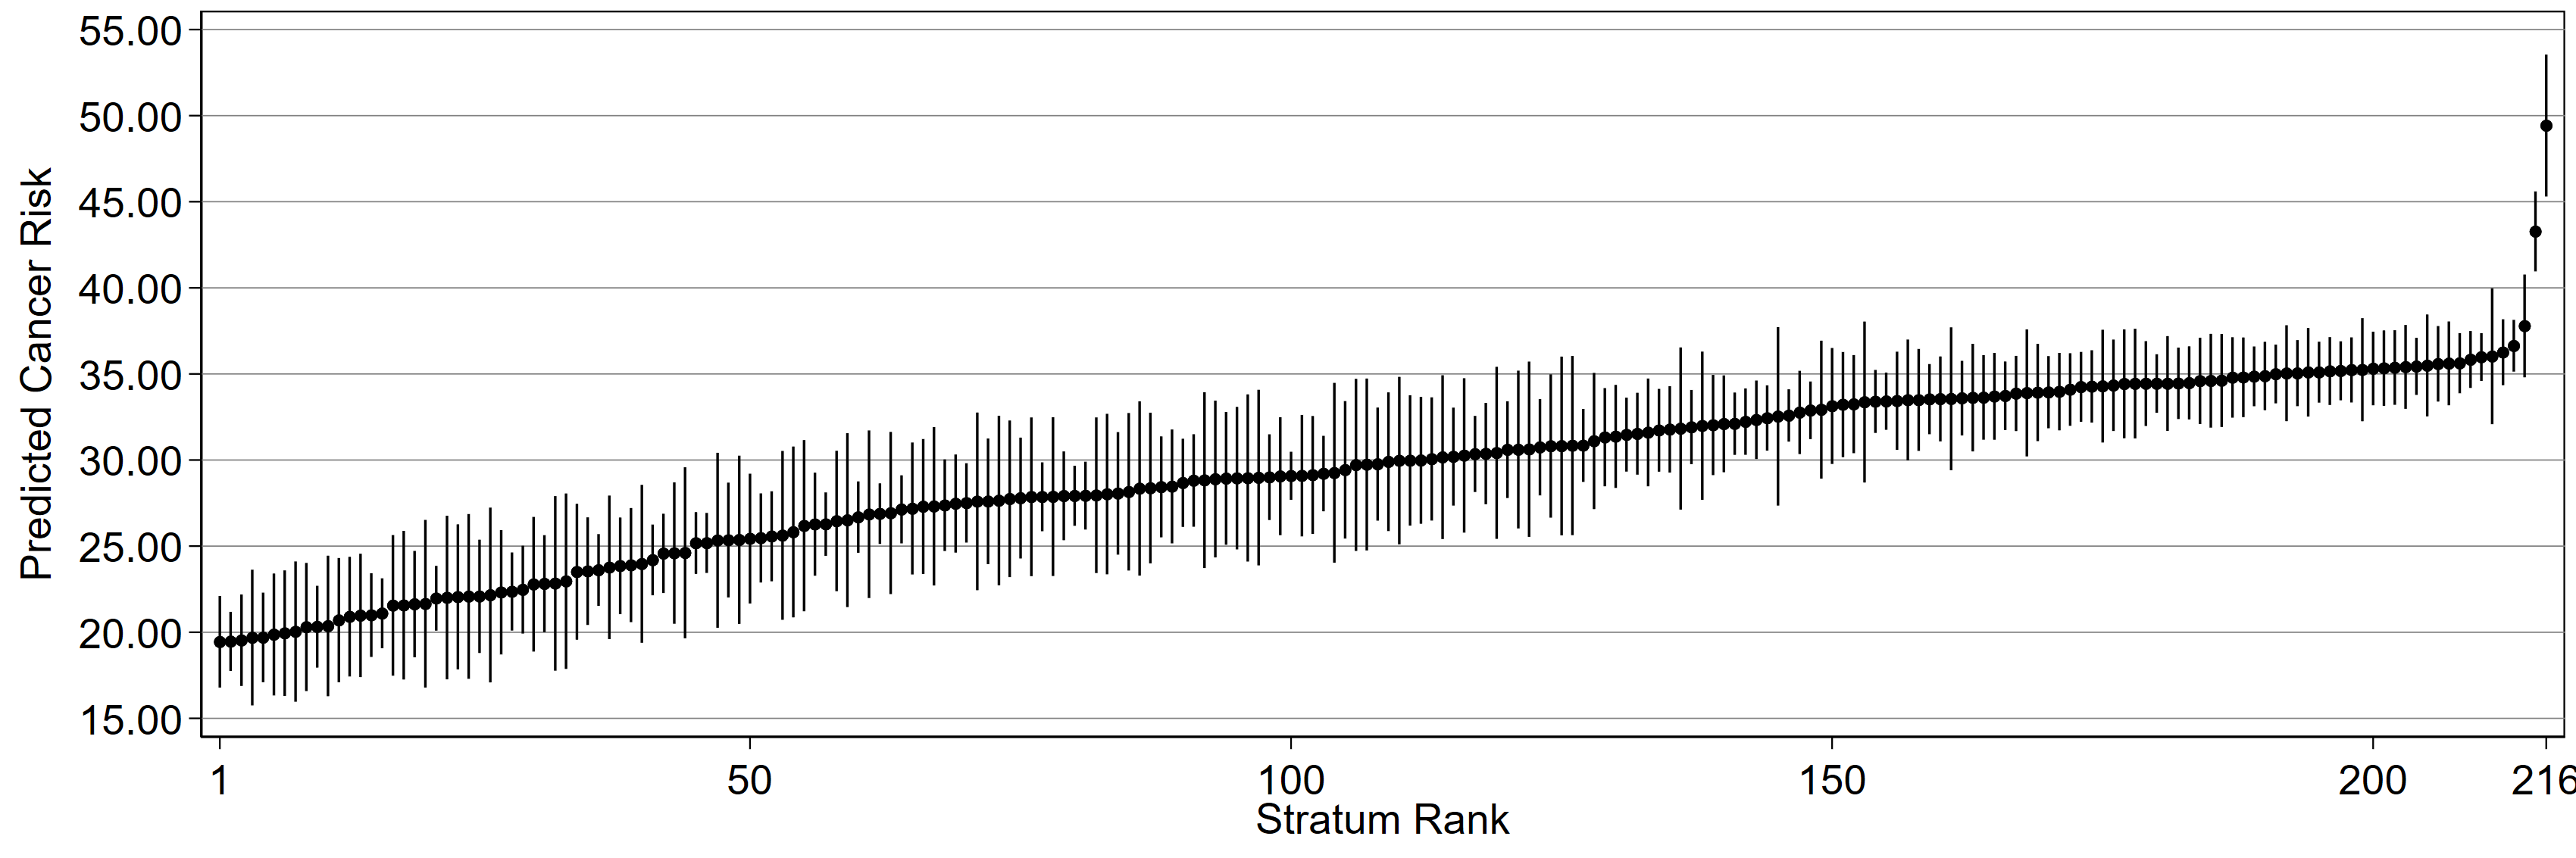

In [52]:
*Make top ten lowest and highest of predicted value
qui{
    use "modelBresults_freq.dta", clear
    gen keepforplot = .
    replace keepforplot = 1 if rank_exp > 206
    replace keepforplot = 1 if rank_exp < 11
    drop if keepforplot == .
    sort rank_exp
    gen plotorder = .
    replace plotorder = 1 if rank_exp == 1
    replace plotorder = 2 if rank_exp == 2
    replace plotorder = 3 if rank_exp == 3
    replace plotorder = 4 if rank_exp == 4
    replace plotorder = 5 if rank_exp == 5
    replace plotorder = 6 if rank_exp == 6
    replace plotorder = 7 if rank_exp == 7
    replace plotorder = 8 if rank_exp == 8
    replace plotorder = 9 if rank_exp == 9
    replace plotorder = 10 if rank_exp == 10
    replace plotorder = 11 if rank_exp == 207
    replace plotorder = 12 if rank_exp == 208
    replace plotorder = 13 if rank_exp == 209
    replace plotorder = 14 if rank_exp == 210
    replace plotorder = 15 if rank_exp == 211
    replace plotorder = 16 if rank_exp == 212
    replace plotorder = 17 if rank_exp == 213
    replace plotorder = 18 if rank_exp == 214
    replace plotorder = 19 if rank_exp == 215
    replace plotorder = 20 if rank_exp == 216
}

twoway ///
    (scatter exp plotorder, mcolor(black) msymbol(circle) mlabel(stratum) mlabposition(12) mlabangle(90) mlabgap(12) mlabsize(medium)) ///
    (rspike exphi explo plotorder, lcolor(black)), ////
    ytitle("Predicted Cancer Risk", size(large)) ///
    text(57 5 "Ten Lowest", place(c)) ///
    text(57 15 "Ten Highest", place(c)) ///
    ylabel( 15 20 25 30 35 40 45 50 55 60, angle(horizontal) format(%9.2f) labsize(large)) ///
    yline( 15 20 25 30 35 40 45 50 55 60, lwidth(vthin) lcolor(gray)) ///
    xtitle("Stratum Rank", size(large)) ///
    xlabel(, nolabel notick) ///
    xline(10.3, lwidth(thin)) ///
    legend(off) ///
    scheme(s1mono)
graph export "Fig_MB_ExpValvsRank_TOPTENS_freq.png", replace width(3400)



. cap noi twoway     (scatter exp plotorder, mcolor(black) msymbol(circle) mlabe
> l(stratum) mlabposition(12) mlabangle(90) mlabgap(12) mlabsize(medium))     (r
> spike exphi explo plotorder, lcolor(black)),     ytitle("Predicted Cancer Risk
> ", size(large))     text(57 5 "Ten Lowest", place(c))     text(57 15 "Ten High
> est", place(c))     ylabel( 15 20 25 30 35 40 45 50 55 60, angle(horizontal) f
> ormat(%9.2f) labsize(large))     yline( 15 20 25 30 35 40 45 50 55 60, lwidth(
> vthin) lcolor(gray))     xtitle("Stratum Rank", size(large))     xlabel(, nola
> bel notick)     xline(10.3, lwidth(thin))     legend(off)     scheme(s1mono)

. if _rc == 0 {
.     noi gr export `"C:/Users/acade/.stata_kernel_cache/graph$stata_kernel_grap
> h_counter.svg"', width(600) replace
file C:/Users/acade/.stata_kernel_cache/graph9.svg saved as SVG format
.     noi gr export `"C:/Users/acade/.stata_kernel_cache/graph$stata_kernel_grap
> h_counter.pdf"', replace
file C:/Users/acade/.stata_kernel_cac

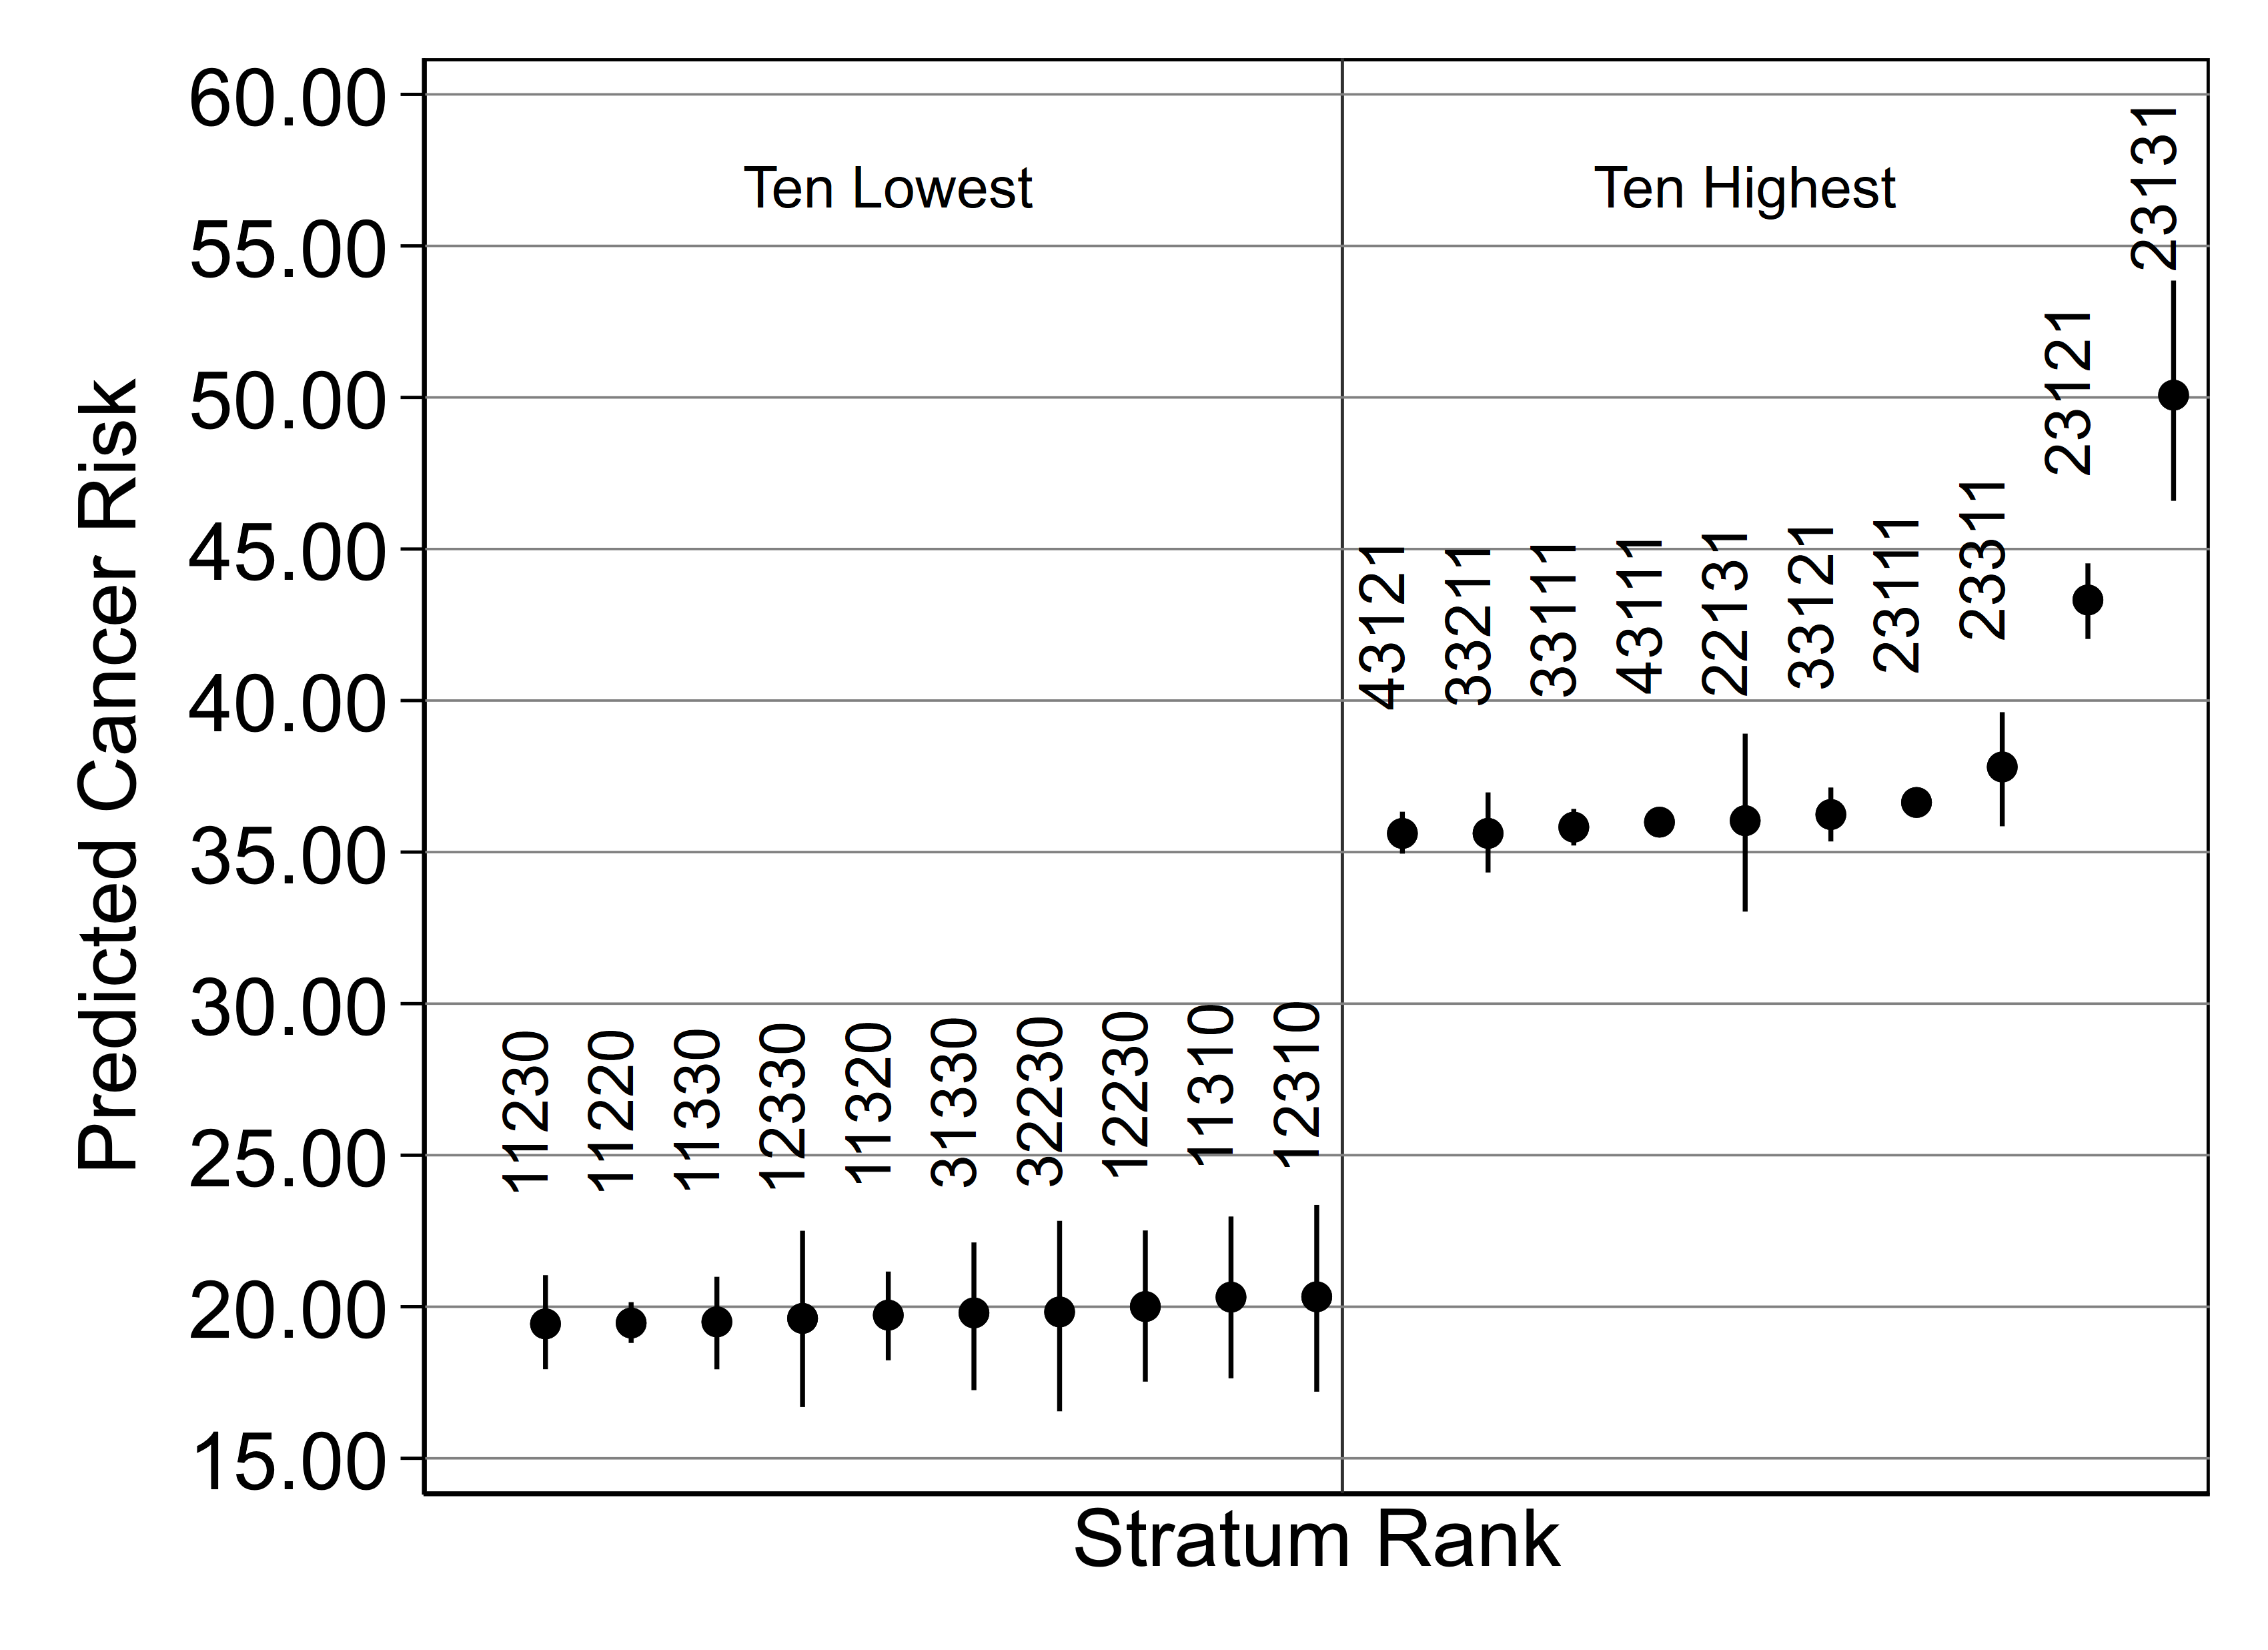

<B>MAKING PLOTS WITH BAYESIAN APPROACH DATA</B>

With the bayesian results. We can look make a table showing the expected values for each stratum and their expected value ranking.

In [5]:
use "modelBresults.dta", clear
list stratum expmn explo exphi exprank


(ICQCM practice data for workshop)


     +----------------------------------------------+
     | stratum    expmn    explo    exphi   exprank |
     |----------------------------------------------|
  1. |   11110   24.195   23.196   25.232        41 |
  2. |   11111   28.709   27.131   30.285        90 |
  3. |   11120   21.975   21.115   22.837        23 |
  4. |   11121   26.684   25.666   27.695        60 |
  5. |   11130   21.618   18.702   24.530        19 |
     |----------------------------------------------|
  6. |   11131   26.219   24.235   28.047        56 |
  7. |   11210   20.344   19.006   21.634        11 |
  8. |   11211   28.802   27.070   30.392        91 |
  9. |   11220   19.464   18.805   20.150         2 |
 10. |   11221   25.168   24.414   25.872        45 |
     |----------------------------------------------|
 11. |   11230   19.435   17.940   21.041         1 |
 12. |   11231   25.185   24.479   25.827        46 |
 13. |   11310   20.318   17.638   22.978   

     |----------------------------------------------|
126. |   31331   32.587   32.077   33.058       146 |
127. |   32110   25.564   24.005   27.077        52 |
128. |   32111   34.119   33.100   35.157       172 |
129. |   32120   23.837   22.123   25.683        39 |
130. |   32121   34.449   33.450   35.525       180 |
     |----------------------------------------------|
131. |   32130   25.575   21.452   29.782        53 |
132. |   32131   34.494   32.511   36.618       182 |
133. |   32210   22.796   21.076   24.620        31 |
134. |   32211   31.720   30.401   33.130       134 |
135. |   32220   22.489   21.118   23.887        29 |
     |----------------------------------------------|
136. |   32221   32.112   31.276   32.881       141 |
137. |   32230   19.828   16.549   22.834         7 |
138. |   32231   32.235   31.377   33.094       142 |
139. |   32310   23.745   20.743   26.901        37 |
140. |   32311   29.748   27.436   32.038       107 |
     |----------------------

From this data, we are going to make caterpillar plots.

This makes a ranked caterpillar plot of the predicted values from Model B (additive model) with the credible intervals.

In [53]:
use "modelBresults.dta", clear
/* without labels */
twoway (scatter expmn exprank, xscale(range(1, 108)) mcolor(black) msymbol(smcircle)) ///
    (rspike exphi explo exprank, lcolor(black)) ////
    , ////
    graphregion(margin(small)) ///
    ytitle("Predicted Cancer Risk", size(large)) ///
    ylabel(15 20 25 30 35 40 45 50 55, angle(horizontal) format(%9.2f) labsize(large)) ///
    yline( 15 20 25 30 35 40 45 50 55, lwidth(vthin) lcolor(gray)) ///
    xtitle("Stratum Rank", size(large)) ///
    xlabel(1 50 100 150 200 216, labsize(large)) ///
    xsize(12) ///
    legend(off) ///
    scheme(s1mono)
graph export "Fig_MB_ExpValvsRank.png", replace width(3400)


(ICQCM practice data for workshop)


file C:/Users/acade/.stata_kernel_cache/graph10.svg saved as SVG format
file C:/Users/acade/.stata_kernel_cache/graph10.pdf saved as PDF format

(file Fig_MB_ExpValvsRank.png not found)
file Fig_MB_ExpValvsRank.png saved as PNG format


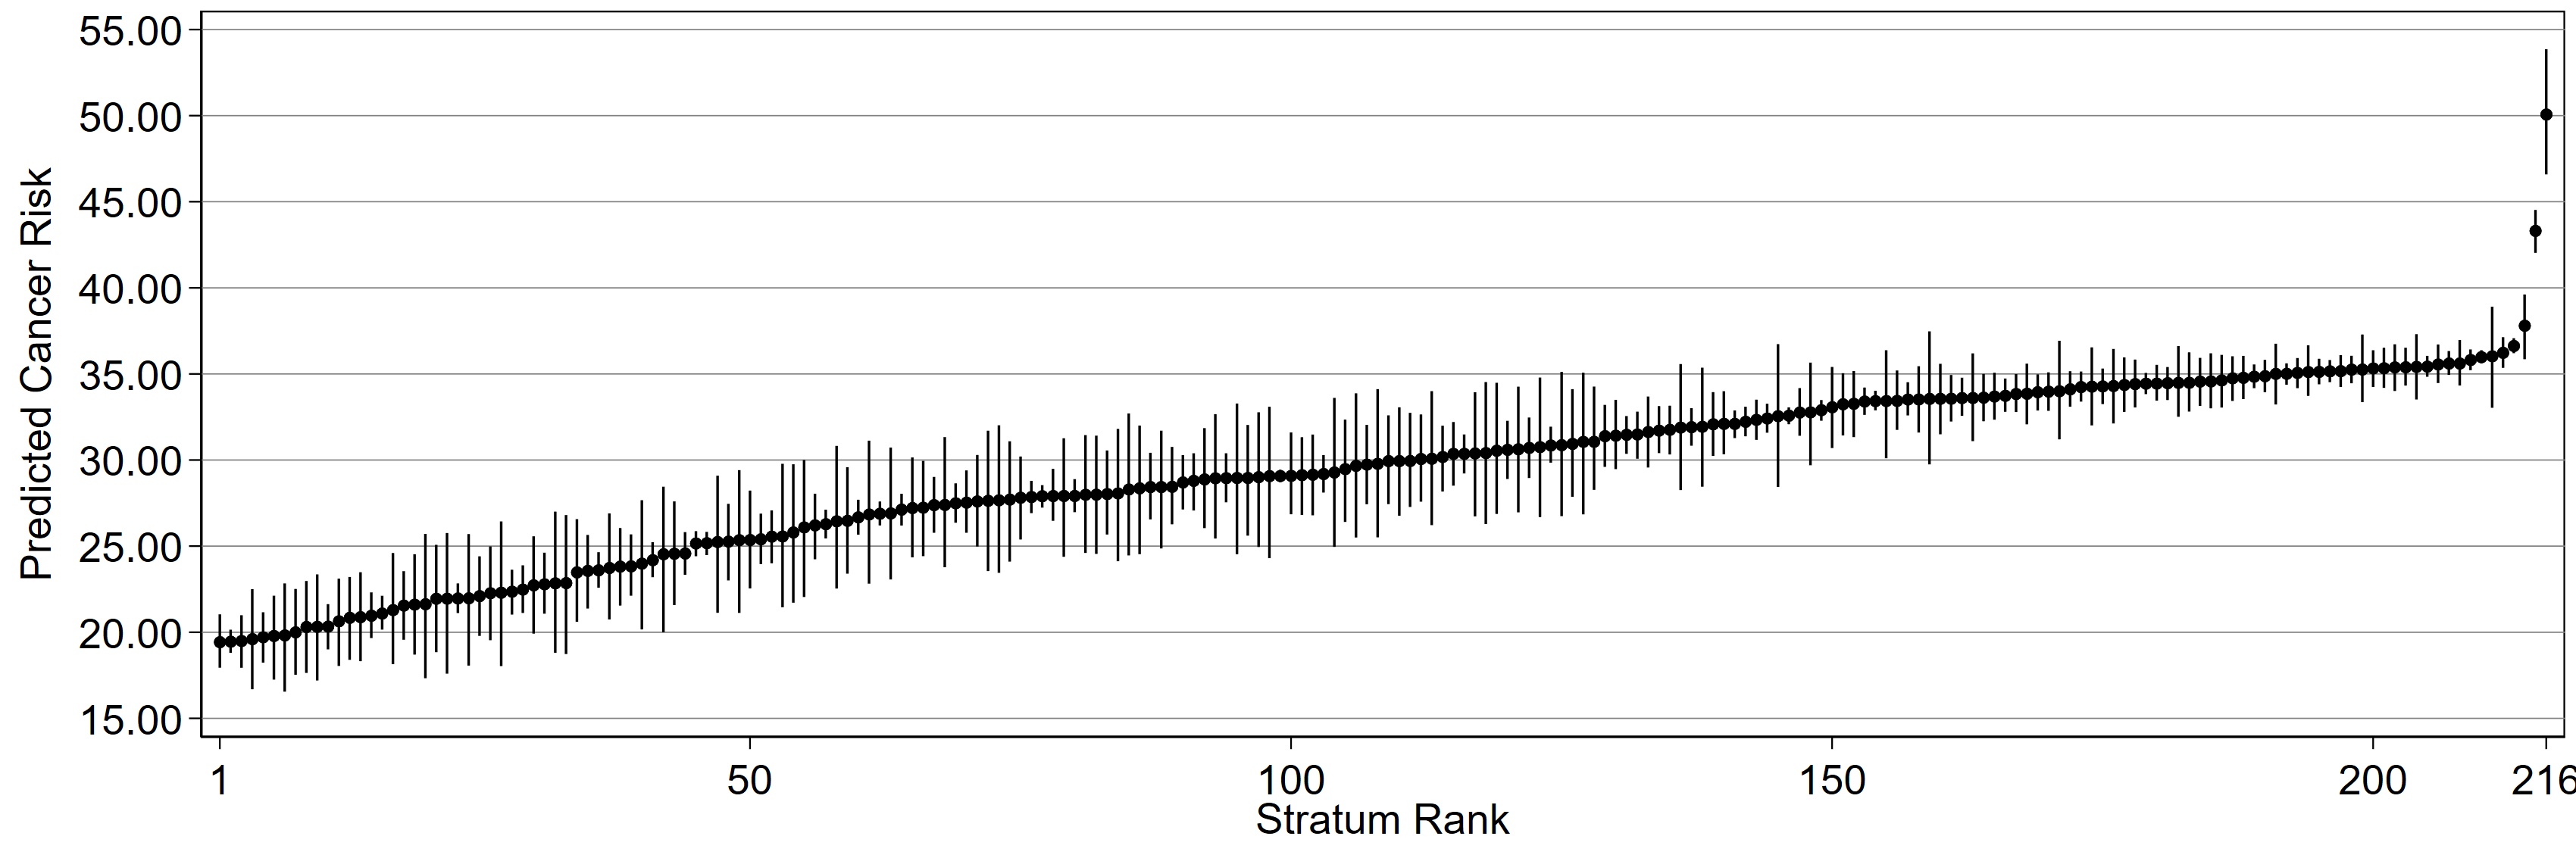

This makes a plot that zooms into the top ten lowest and highest and labels the stratum.

In [54]:
*Make top ten lowest and highest of predicted value
qui{
    use "modelBresults.dta", clear
    gen keepforplot = .
    replace keepforplot = 1 if exprank > 206
    replace keepforplot = 1 if exprank < 11
    drop if keepforplot == .
    sort exprank
    gen plotorder = .
    replace plotorder = 1 if exprank == 1
    replace plotorder = 2 if exprank == 2
    replace plotorder = 3 if exprank == 3
    replace plotorder = 4 if exprank == 4
    replace plotorder = 5 if exprank == 5
    replace plotorder = 6 if exprank == 6
    replace plotorder = 7 if exprank == 7
    replace plotorder = 8 if exprank == 8
    replace plotorder = 9 if exprank == 9
    replace plotorder = 10 if exprank == 10
    replace plotorder = 11 if exprank == 207
    replace plotorder = 12 if exprank == 208
    replace plotorder = 13 if exprank == 209
    replace plotorder = 14 if exprank == 210
    replace plotorder = 15 if exprank == 211
    replace plotorder = 16 if exprank == 212
    replace plotorder = 17 if exprank == 213
    replace plotorder = 18 if exprank == 214
    replace plotorder = 19 if exprank == 215
    replace plotorder = 20 if exprank == 216
}

twoway ///
    (scatter expmn plotorder, mcolor(black) msymbol(circle) mlabel(stratum) mlabposition(12) mlabangle(90) mlabgap(12) mlabsize(medium)) ///
    (rspike exphi explo plotorder, lcolor(black)) ////
    , ////
    ytitle("Predicted Cancer Risk", size(large)) ///
    text(57 5 "Ten Lowest", place(c)) ///
    text(57 15 "Ten Highest", place(c)) ///
    ylabel( 15 20 25 30 35 40 45 50 55 60, angle(horizontal) format(%9.2f) labsize(large)) ///
    yline( 15 20 25 30 35 40 45 50 55 60, lwidth(vthin) lcolor(gray)) ///
    xtitle("Stratum Rank", size(large)) ///
    xlabel(, nolabel notick) ///
    xline(10.3, lwidth(thin)) ///
    legend(off) ///
    scheme(s1mono)
graph export "Fig_MB_ExpValvsRank_TOPTENS.png", replace width(3400)



. cap noi twoway     (scatter expmn plotorder, mcolor(black) msymbol(circle) mla
> bel(stratum) mlabposition(12) mlabangle(90) mlabgap(12) mlabsize(medium))     
> (rspike exphi explo plotorder, lcolor(black))     ,     ytitle("Predicted Canc
> er Risk", size(large))     text(57 5 "Ten Lowest", place(c))     text(57 15 "T
> en Highest", place(c))     ylabel( 15 20 25 30 35 40 45 50 55 60, angle(horizo
> ntal) format(%9.2f) labsize(large))     yline( 15 20 25 30 35 40 45 50 55 60, 
> lwidth(vthin) lcolor(gray))     xtitle("Stratum Rank", size(large))     xlabel
> (, nolabel notick)     xline(10.3, lwidth(thin))     legend(off)     scheme(s1
> mono)

. if _rc == 0 {
.     noi gr export `"C:/Users/acade/.stata_kernel_cache/graph$stata_kernel_grap
> h_counter.svg"', width(600) replace
file C:/Users/acade/.stata_kernel_cache/graph11.svg saved as SVG format
.     noi gr export `"C:/Users/acade/.stata_kernel_cache/graph$stata_kernel_grap
> h_counter.pdf"', replace
file C:/Users/acade/.stata

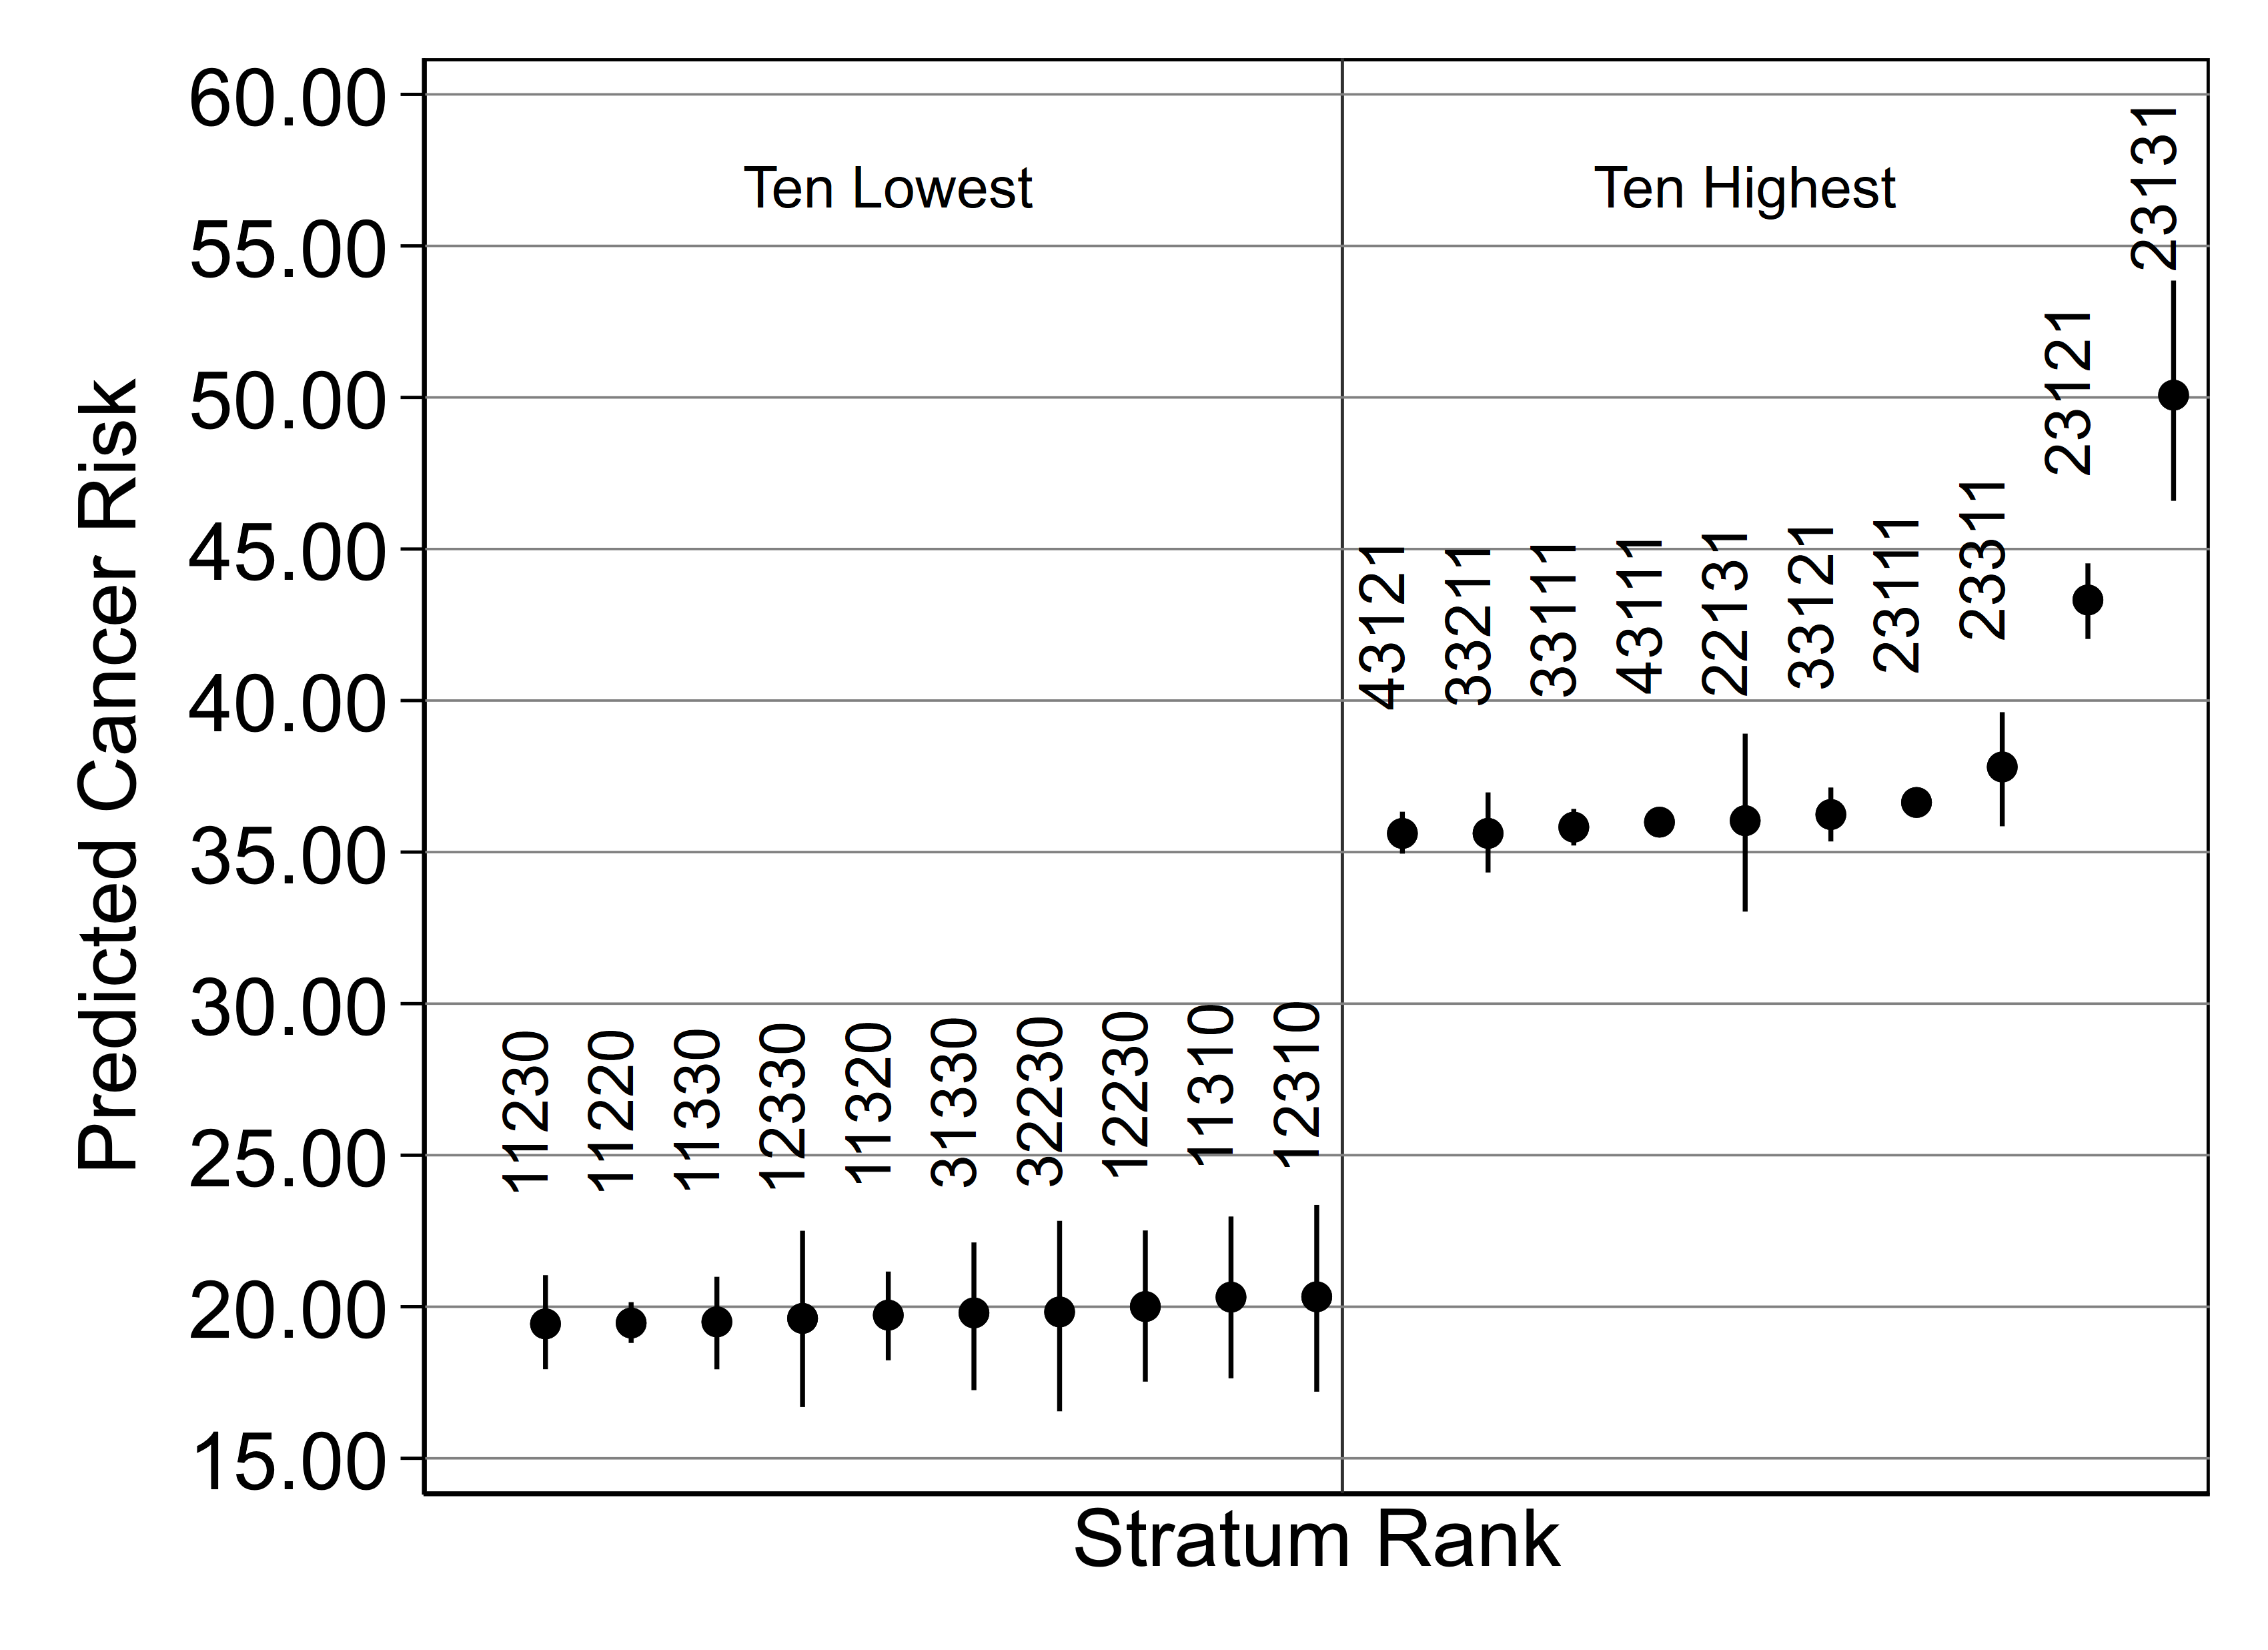

That concludes this walkthrough. I hope it was helpful.